In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import pickle
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc, font_manager
ticks_font = font_manager.FontProperties(family='serif', style='normal',
                                         size=24, weight='normal', stretch='normal')
from scipy.spatial import ConvexHull
from GPyOpt.util.general import get_quantiles
import plotly.graph_objs as go
%matplotlib inline
import plotly.express as px
from sklearn.metrics import mean_squared_error
import json
import random

In [23]:
# my own tools
from bgotools.suggest_experiments import suggest_next 
from bgotools.my_acquisitions import EI_global_min
from bgotools.my_hull_funcs import my_hull_funcs 
from bgotools.set_pool import set_pool


In [3]:
# for training data
def f(x):
    try:
        return np.float(x)
    except:
        return np.nan

In [5]:
# read the query data formation_energy, clex, corr
data_save = pd.read_csv('./BGO_EI_data',sep='\s+')
#data_save = pd.read_csv('./trimmed_data',sep=',')



In [6]:

data = data_save

In [7]:
# process data 
data['clex()'] = data['clex()'].apply(f)
calculated_data = data['formation_energy'].notnull()
# calculated data
X_data_all = data[calculated_data]['comp(a)']
Y_data_all = data[calculated_data]['clex()']

len(X_data_all)#number of calculated data

58165

In [8]:
# get convex hull 
my_hull = my_hull_funcs(X_data_all,Y_data_all)
my_hull.get_bottom_hull()
true_convex_hull, true_convex_hull_index = my_hull.bt_hull_points, my_hull.bt_hull_vertices
hull_function = my_hull.bt_hull_facets
my_hull.shoelace_area()

In [9]:
random.seed(101)
#Number of initial data pool (user)
N_init = 30
init_idxs = random.sample(range(len(data)),N_init)

if data[data['comp(a)']==0].index[0] not in init_idxs:
    init_idxs.append(data[data['comp(a)']==0].index[0])
if data[data['comp(a)']==1].index[0] not in init_idxs:
    init_idxs.append(data[data['comp(a)']==1].index[0])

In [10]:
# start making inputs for GPyOpt
# Y property for training/prediction
Y_name = 'clex()' 
# training pool
N_train = len(init_idxs)
train_index = init_idxs
# design pool
N_design = len(data)
design_index = (range(len(data)))
# corrs 
num_corrs = sum('corr' in s for s in data.columns)
selected_corrs = np.ones(num_corrs) # all correlation functions
# set_pool make the training pool and design pool according to the above settings
my_pool = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)

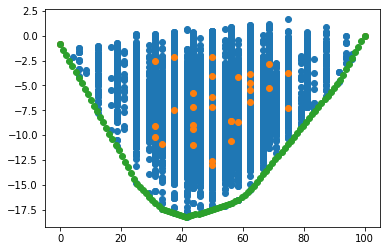

In [11]:
# interactive plot calculated
# visualization of the DFT hull 


plt.scatter(data['comp(a)']*100, data['clex()']*1000/8)
plt.scatter( my_pool.train_comp*100, my_pool.train_Y*1000/8)
hull_x_grid = np.linspace(0,1,100)
plt.scatter(hull_x_grid*100,my_hull.bt_hull_facets(hull_x_grid)*1000/8)
#fig.add_scatter(x = hull_x_grid*100,y = my_Af.predicted_hull.bt_hull_facets(hull_x_grid)*1000/8)
#plt.scatter(hull_x_grid*100,known_hull.bt_hull_facets(hull_x_grid)*1000/8)
plt.show()

In [12]:
# remind properties inside my_pool
'''
my_pool.train_X
my_pool.train_Y 
my_pool.train_comp
my_pool.design_X
my_pool.design_comp
'''
## define some parameters for fitting
max_iteration = 10
tolerance = 1e-3
fixed_noise=1e-6



In [13]:
# remind the initial training data pool 
X_train = my_pool.train_X
Y_train = my_pool.train_Y_nd
done_experiments_id_list = [x for x in my_pool.train_index]
# remind the design data pool
X_design = my_pool.design_X
#design_idxs
# remind the formation energy calculation from the ECIs
#eci_list
#CE_formation_energy
# 
# 
# remind the true ground state line
true_convex_hull_X = data['comp(a)'][true_convex_hull_index]
true_convex_hull_Y = data['clex()'][true_convex_hull_index]
X_list = np.linspace(0,1,100)

In [14]:
GPModelClass=GPy.models.GPRegression

In [15]:
kernel = GPy.kern.RBF(X_train.shape[1], ARD=True)
model = GPModelClass(X_train, Y_train, kernel)
model.Gaussian_noise.variance.constrain_fixed(fixed_noise)
model.optimize_restarts(20, verbose=False)

In [16]:
known_hull = my_hull_funcs(my_pool.train_comp,my_pool.train_Y)
known_hull.get_bottom_hull()
known_hull.shoelace_area()

In [24]:
class EI_global_min:

    def __init__(self,
                design_X,
                design_comp,
                model,
                hull_function,
                xi=0.0,
                mode='min'
                ):
        """
        Compute the Expected Improvement at (X_i, comp_i). 
        
        design_X: Compositions of the training data set
        
        design_comp: Compositions of the design data set
        
        model: BG.regression
        
        mode: minimize or maximize the current Y profile, default is min

        xi: parameter for EI, read Brochu's paper for details, a safe value of 0.01 is good
        """
        self.design_X = design_X
        self.design_comp = design_comp
        self.model = model
        self.hull_function = hull_function
        self.xi = xi
        self.mode = mode 

    def EI(self):
        
        m_s, v_s = self.model.predict(self.design_X)[:2] 
        m_s = m_s.flatten() # mean 
        v_s = v_s.flatten() # variance
        # fmin: convex hull
        fmins = min(self.hull_function(self.design_comp).flatten())
        #print(fmins)
        self.predictive_mean = m_s
        self.predictive_variance = v_s
        # self.design_X, m_s, v_s, design_comp, and fmins are for the same configurations 
        # variance too small will not be important
        if isinstance(v_s, np.ndarray):
            v_s[v_s<1e-10] = 1e-10
        elif v_s< 1e-10:
            v_s = 1e-10

        if self.mode == 'min':
            # find the function minimum.
            u = (fmins - m_s - self.xi) / v_s
        elif self.mode == 'max':
            # find the function maximum.
            u = (m_s - fmins - self.xi) / v_s
        else:
            print('I do not know what to do with mode %s' %self.mode)
        self.ei = v_s * (u * stats.norm.cdf(u) + stats.norm.pdf(u))
        
        return (self.ei)

In [32]:
#start iterations from here
train_index_update = train_index
my_pool_update = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)
len(my_pool_update.train_comp),len(my_pool_update.train_Y)

(32, 32)

In [33]:
max_iteration = 6

In [34]:
saved_model_list = []
next_experiment_id_list = []
next_experiment_idxs_non_duplicated_list = []
af_max_ei_list = []
af_ei_list = []
# Af_evolve documents all the Af/EI for all iterations
# in an Af of one iteration, we can get 
# 1. EI of hull
# 2. predicted area
# 3. predicted mean/variance of configurations
# 4. predicted hull -> all configurations
# 5. predicted hull subsets -> combinations
# 6. predicted hull functions -> for plotting the hull

Af_evolve = []


# start optimization 
#for it in range(max_iteration):
for it in range(max_iteration):
    print('> Iteration: {}'.format(it))
    print('Number of data points observed: {}'.format(len(my_pool_update.train_Y_nd)))
    # setup model
    kernel = GPy.kern.RBF(my_pool_update.train_X.shape[1], ARD=True)
    model = GPModelClass(my_pool_update.train_X, my_pool_update.train_Y_nd, kernel)
    if fixed_noise is not None:
        model.Gaussian_noise.variance.unconstrain()
        model.Gaussian_noise.variance.constrain_fixed(fixed_noise)
        
    # start fitting
    model.optimize_restarts(20, verbose=False)
    saved_model_list.append(model)
    # fitting finished, get EI
    known_hull = my_hull_funcs(my_pool_update.train_comp,my_pool_update.train_Y)
    known_hull.get_bottom_hull()
    #####
    #####
    #####
    my_Af = EI_global_min(my_pool_update.design_X,
                     my_pool_update.design_comp,
                     model,
                     known_hull.bt_hull_facets)
    
    my_Af.EI()
    ei = my_Af.ei 
    i = np.argmax(ei)
    af_max_ei0 = ei[i]
    Af_evolve.append(my_Af)
    af_max_ei_list.append(af_max_ei0)
    #####
    #####
    #####
    # rank configurations according to ei and pick a batch from the top
    sorted_ei = [sorted(range(len(my_Af.ei)), key=lambda i: my_Af.ei[i],reverse=True)][0]
    next_experiment_idxs_non_duplicated = []
    
    for config in sorted_ei:
        if len(next_experiment_idxs_non_duplicated)<5: # pick a batch of 5
            if config not in train_index_update:
                next_experiment_idxs_non_duplicated.append(config)
    
    #####
    #####
    #####
    
    # determine whether next fitting is necessary 
    if af_max_ei0 / af_max_ei_list[0] <= tolerance:
        print('*** Converged (af[i] / afmax0 = {0:1.7f}) < {1:e}'.format(af_max_ei0 / af_max_ei_list[0], tolerance))
        
    # append predicted configurations to the updating training pool (observations)
    train_index_update = train_index_update + next_experiment_idxs_non_duplicated
    my_pool_update = set_pool(data,train_index_update,design_index,selected_corrs,Y_name,ternary=False)
    next_experiment_idxs_non_duplicated_list.append(next_experiment_idxs_non_duplicated)
    print('Selected Structures: {}'.format(next_experiment_idxs_non_duplicated))
    
    print('Max EI = {}'.format(af_max_ei0 / af_max_ei_list[0]))
    print('Min Energy Observed: {}'.format(my_pool_update.train_Y.min()))

> Iteration: 0
Number of data points observed: 32
Selected Structures: [22227, 37831, 20, 3054, 6599]
Max EI = 1.0
Min Energy Observed: -0.12568881
> Iteration: 1
Number of data points observed: 37
Selected Structures: [54065, 51775, 23044, 39484, 54176]
Max EI = 0.7845865178639068
Min Energy Observed: -0.14596631
> Iteration: 2
Number of data points observed: 42
Selected Structures: [21, 1, 2, 3, 4]
Max EI = 0.05570062554052911
Min Energy Observed: -0.14596631
> Iteration: 3
Number of data points observed: 47
Selected Structures: [23042, 39482, 51786, 51819, 5]
Max EI = 0.5792061279395201
Min Energy Observed: -0.14596631
> Iteration: 4
Number of data points observed: 52
*** Converged (af[i] / afmax0 = 0.0000000) < 1.000000e-03
Selected Structures: [6, 7, 8, 9, 10]
Max EI = 0.0
Min Energy Observed: -0.14596631
> Iteration: 5
Number of data points observed: 57
*** Converged (af[i] / afmax0 = 0.0000000) < 1.000000e-03
Selected Structures: [11, 12, 13, 14, 15]
Max EI = 1.3743854014027684e

In [41]:
## Now to test randomness
## setup 10 independent runs using the same starting training set
## document the results from these 20 runs
n_runs = 10
max_iteration = 11
r_train_index_update = []
r_my_pool_update = []
r_saved_model_list = []
r_next_experiment_id_list = []
r_next_experiment_idxs_list_non_duplicated = []
r_af_max_ei_list = []
r_af_ei_list = []
r_Af_evolve = []
r_hull_evolve = []
r_fit_hull_evolve = []
for run_i in range(n_runs):
    train_index_update = train_index
    my_pool_update = set_pool(data,train_index,design_index,selected_corrs,Y_name,ternary=False)
    print('>>>Starting {} run.'.format(run_i))
    saved_model_list = []
    next_experiment_id_list = []
    next_experiment_idxs_non_duplicated_list = []
    af_max_ei_list = []
    af_ei_list = []
    
    # Af_evolve documents all the Af/EI for all iterations
    # in an Af of one iteration, we can get 
    # 1. EI of hull
    # 2. predicted area
    # 3. predicted mean/variance of configurations
    # 4. predicted hull -> all configurations
    # 5. predicted hull subsets -> combinations
    # 6. predicted hull functions -> for plotting the hull

    Af_evolve = []
    hull_evolve = []
    fit_hull_evolve = []

    # start optimization 
    for it in range(max_iteration):
        print('> Iteration: {}'.format(it))
        print('Number of data points observed: {}'.format(len(my_pool_update.train_Y_nd)))
        # setup model
        kernel = GPy.kern.RBF(my_pool_update.train_X.shape[1], ARD=True)
        model = GPModelClass(my_pool_update.train_X, my_pool_update.train_Y_nd, kernel)
        if fixed_noise is not None:
            model.Gaussian_noise.variance.unconstrain()
            model.Gaussian_noise.variance.constrain_fixed(fixed_noise)

        # start fitting
        model.optimize_restarts(20, verbose=False)
        saved_model_list.append(model)
        # fitting finished, get EI
        known_hull = my_hull_funcs(my_pool_update.train_comp,my_pool_update.train_Y)
        known_hull.get_bottom_hull()
        #####
        #####
        #####
        my_Af = EI_global_min(my_pool_update.design_X,
                         my_pool_update.design_comp,
                         model,
                         known_hull.bt_hull_facets)
        
        my_Af.EI()
        ei = my_Af.ei 
        i = np.argmax(ei)
        af_max_ei0 = ei[i]
        Af_evolve.append(my_Af)
        af_max_ei_list.append(af_max_ei0)
        hull_evolve.append(known_hull.bt_hull_facets)
        
        fit_hull = my_hull_funcs(my_Af.design_comp,my_Af.predictive_mean)
        fit_hull.get_bottom_hull()
        fit_hull_evolve.append(fit_hull.bt_hull_facets)
        #####
        #####
        #####
        # rank configurations according to ei and pick a batch from the top
        sorted_ei = [sorted(range(len(my_Af.ei)), key=lambda i: my_Af.ei[i],reverse=True)][0]
        next_experiment_idxs_non_duplicated = []

        for config in sorted_ei:
            if config>sorted_ei[0]/1e5: #
                if len(next_experiment_idxs_non_duplicated)<5: # pick a batch of 5
                    if config not in train_index_update:
                        next_experiment_idxs_non_duplicated.append(config)

        #####
        #####
        #####

        # determine whether next fitting is necessary 
        if af_max_ei0 / af_max_ei_list[0] <= tolerance:
            print('*** Converged (af[i] / afmax0 = {0:1.7f}) < {1:e}'.format(af_max_ei0 / af_max_ei_list[0], tolerance))

        # append predicted configurations to the updating training pool (observations)
        train_index_update = train_index_update + next_experiment_idxs_non_duplicated
        my_pool_update = set_pool(data,train_index_update,design_index,selected_corrs,Y_name,ternary=False)
        next_experiment_idxs_non_duplicated_list.append(next_experiment_idxs_non_duplicated)
        print('Selected Structures: {}'.format(next_experiment_idxs_non_duplicated))

        print('Max EI = {}'.format(af_max_ei0 / af_max_ei_list[0]))
        print('Min Energy Observed: {}'.format(my_pool_update.train_Y.min()))
    r_hull_evolve.append(hull_evolve)
    r_fit_hull_evolve.append(fit_hull_evolve)

>>>Starting 0 run.
> Iteration: 0
Number of data points observed: 32
Selected Structures: [51553, 51461, 56605, 51460, 53212]
Max EI = 1.0
Min Energy Observed: -0.13795585
> Iteration: 1
Number of data points observed: 37
Selected Structures: [19466, 31323, 35906, 47763, 31305]
Max EI = 0.19320567416014606
Min Energy Observed: -0.13795585
> Iteration: 2
Number of data points observed: 42
Selected Structures: [51719, 51708, 1, 2, 3]
Max EI = 0.19084276251829557
Min Energy Observed: -0.13795585
> Iteration: 3
Number of data points observed: 47
Selected Structures: [22, 6604, 51730, 51764, 6603]
Max EI = 0.5332034016632689
Min Energy Observed: -0.13795585
> Iteration: 4
Number of data points observed: 52
Selected Structures: [54065, 54176, 51742, 51775, 21]
Max EI = 0.36581779522409036
Min Energy Observed: -0.14596631
> Iteration: 5
Number of data points observed: 57
*** Converged (af[i] / afmax0 = 0.0000000) < 1.000000e-03
Selected Structures: [4, 5, 6, 7, 8]
Max EI = 0.0
Min Energy Obse

In [32]:
r_n_h_config = []
for i in range(len(r_train_index_update)):
    t_i = r_train_index_update[i]
    n_h_config = []
    for config in true_convex_hull_index:
        if config in t_i:
            n_h_config.append(config)
    r_n_h_config.append(n_h_config)
    print('Run-{}'.format(i))
    print('Predicted hull configs: {}/{}'.format(len(n_h_config),len(true_convex_hull)))